In [64]:
import torch
import numpy as np
# import torch.nn.functional as F


In [65]:
import torch
import kornia.geometry.transform as kornia_transform

class ShiftImage:
    def __init__(self, max_shift_x=50, max_shift_y=50):
        self.max_shift_x = max_shift_x
        self.max_shift_y = max_shift_y

    def __call__(self, tensor: torch.Tensor, shift: tuple = None) -> torch.Tensor:
        # If no shift is provided, raise an error
        if shift is None:
            raise ValueError("Shift values must be explicitly provided.")

        shift_x, shift_y = shift
        translation = torch.tensor([[shift_x, shift_y]], dtype=torch.double)

        return kornia_transform.translate(
            tensor.unsqueeze(0).double(),
            translation,
            mode="bilinear",
            padding_mode="border",
            align_corners=True,
        ).squeeze(0).float()

class RotateImage:
    def __init__(self, center=None, mode='bilinear', padding_mode='border', align_corners=True):
        self.center = center
        self.mode = mode
        self.padding_mode = padding_mode
        self.align_corners = align_corners

    def __call__(self, img, angle):
        # Ensure the input is a tensor
        if not isinstance(img, torch.Tensor):
            raise TypeError("Input must be a tensor")
        
        # # Add a batch dimension if needed (Kornia expects a batch of tensors)
        # if img.ndim == 3:  # [C, H, W]
        #     img = img.unsqueeze(0)  # Add batch dimension [B, C, H, W]
        
        return kornia_transform.rotate(
            img, angle, self.center, self.mode, self.padding_mode, self.align_corners
        )

In [66]:
pre_op = np.load("/home/adil/Documents/TUE/ThesisPrepPhase/myProject/data/test/ReMIND-039_slice_axial_140_pre_label_0.npz")["data"]
post_op = np.load("/home/adil/Documents/TUE/ThesisPrepPhase/myProject/data/test/ReMIND-039_slice_axial_140_post_label_0.npz")["data"]
feature_map_pre = np.load("/home/adil/Documents/TUE/ThesisPrepPhase/myProject/data/test/third_conv_0.npz")['third_conv_0']
feature_map_post = np.load("/home/adil/Documents/TUE/ThesisPrepPhase/myProject/data/test/third_conv_0_post.npz")['third_conv_1']
shift_values = np.load("/home/adil/Documents/TUE/ThesisPrepPhase/myProject/data/test/third_conv_0.npz")['shift_values']
change_map = np.load("/home/adil/Documents/TUE/ThesisPrepPhase/myProject/data/test/ReMIND-039_slice_axial_140_change_map_label_0.npz")['data']
pre_tumor = np.load("/home/adil/Documents/TUE/ThesisPrepPhase/myProject/data/test/ReMIND-039_slice_axial_140_pre_tumor_label_0.npz")['data']
post_tumor = np.load("/home/adil/Documents/TUE/ThesisPrepPhase/myProject/data/test/ReMIND-039_slice_axial_140_post_tumor_label_0.npz")['data']
feature_map_pre = torch.tensor(feature_map_pre)
feature_map_post = torch.tensor(feature_map_post)
pre_op = torch.tensor(pre_op)
post_op = torch.tensor(post_op)
change_map = torch.tensor(change_map)
shift_tensor = ShiftImage()
rotate_Image = RotateImage()

In [67]:
rotation_angle = torch.randint(-180, 181, (1,), dtype=torch.float32)
#post_op = shift_tensor(post_op, shift=(shift_values[0], shift_values[1]))
#change_map = shift_tensor(change_map, shift=(shift_values[0], shift_values[1]))
#post_op = rotate_Image(post_op.unsqueeze(0), rotation_angle)
#change_map = rotate_Image(change_map.unsqueeze(0), rotation_angle)

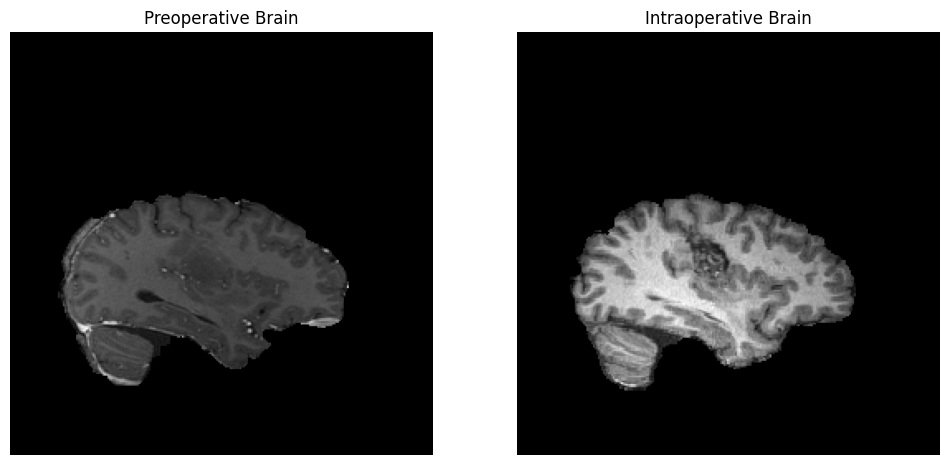

In [68]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plot pre_op
axs[0].imshow(np.rot90(pre_op), cmap='gray')
axs[0].set_title('Preoperative Brain')
axs[0].axis('off')

# Plot post_op
axs[1].imshow(np.rot90(post_op.squeeze(0)), cmap='gray')
axs[1].set_title('Intraoperative Brain')
axs[1].axis('off')

plt.show()

In [69]:
import torch.nn.functional as F
interp = torch.nn.Upsample(size=(256, 256), mode='bilinear')
from numpy import ndarray
import cv2
def normalize_np_array(array: ndarray) -> ndarray:
    if np.max(array) == np.min(array):
        return array
    return (array - np.min(array)) / (np.max(array) - np.min(array))
def various_distance(out_vec_t0, out_vec_t1,dist_flag):
    if dist_flag == 'l2':
        distance = F.pairwise_distance(out_vec_t0, out_vec_t1, p=2)
    if dist_flag == 'l1':
        distance = F.pairwise_distance(out_vec_t0, out_vec_t1, p=1)
    if dist_flag == 'cos':
        distance = 1 - F.cosine_similarity(out_vec_t0, out_vec_t1)
    return distance


def return_upsampled_norm_distance_map(output_t0: torch.Tensor,output_t1: torch.Tensor,dist_flag: str,
                                        mode='bilinear'):

    # interp = torch.nn.Upsample(size=[256,256], mode=mode)
    c, h, w = output_t0.data.shape

    # remember the c, h, w -> flatten
    out_t0_rz = torch.transpose(output_t0.view(c, h * w), 1, 0)
    out_t1_rz = torch.transpose(output_t1.view(c, h * w), 1, 0)
    distance = various_distance(out_t0_rz,out_t1_rz,dist_flag=dist_flag)
    similar_distance_map = distance.view(h,w).data.cpu().numpy()
    
# Convert feature maps to numpy arrays with (h, w) by averaging over channels
    feature_map_t0 = output_t0.squeeze(0).mean(dim=0).cpu().numpy()  # Shape: (32, 32)
    feature_map_t1 = output_t1.squeeze(0).mean(dim=0).cpu().numpy()  # Shape: (32, 32)

    # Convert to 4D tensor for upsampling
    feature_map_t0_rz = interp(torch.from_numpy(feature_map_t0[np.newaxis, np.newaxis, :]))
    feature_map_t1_rz = interp(torch.from_numpy(feature_map_t1[np.newaxis, np.newaxis, :]))


    ## create a 4 dim torch by adding back h, w axis post distance calc 
    
    ## torch upsamle expects b,c,h,w
    ## normalize it after to 0 1
    
    similar_distance_map_rz = interp(torch.from_numpy(similar_distance_map[np.newaxis, np.newaxis, :]))
    normalized_distance_map = normalize_np_array(similar_distance_map_rz.data.cpu().numpy()[0][0])
        # Upsample feature maps

    try:
        assert normalized_distance_map.max() <= 1.0, f"max: {normalized_distance_map.max()}, {normalized_distance_map}, \n {similar_distance_map_rz.data.cpu().numpy()[0][0]}"
        assert normalized_distance_map.min() >= 0.0, f"min: {normalized_distance_map.min()}"
    except AssertionError as e:
        print(f"AssertionError caught: {e}")
    # Save the tensor for further debugging
        save_path = "./debug/similar_distance_map_rz_failed.txt"
        os.makedirs("./debug", exist_ok=True)
        np.savetxt(save_path, similar_distance_map)
    return (
    normalized_distance_map,
    normalize_np_array(feature_map_t0_rz.cpu().numpy()[0, 0]),  # Convert tensor to NumPy
    normalize_np_array(feature_map_t1_rz.cpu().numpy()[0, 0])   # Convert tensor to NumPy
)


In [70]:
distance_map_2d_conv3, phi0, phi1 = return_upsampled_norm_distance_map(
                    feature_map_pre[0], feature_map_post[0], dist_flag='l2', mode='bilinear')

In [71]:
import matplotlib.pyplot as plt


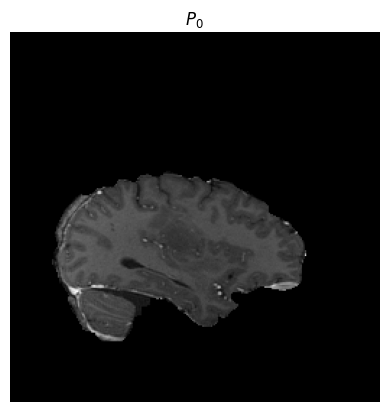

In [72]:
plt.imshow(np.rot90(pre_op), cmap='grey')
# plt.imshow(shifted_change_map, cmap='jet', alpha=0.5)
plt.title('$P_{0}$')
plt.axis('off')
plt.show()

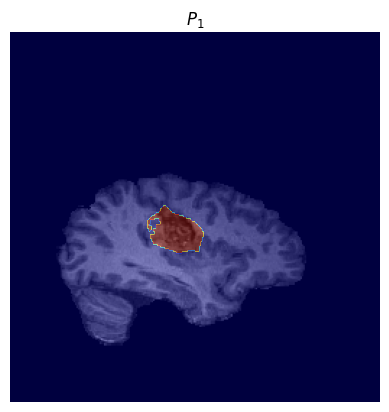

In [73]:
plt.imshow(np.rot90(post_op.squeeze(0)), cmap='grey')
plt.imshow(np.rot90(change_map.squeeze(0)), cmap='jet', alpha=0.5)
plt.title('$P_{1}$')
plt.axis('off')
plt.show()

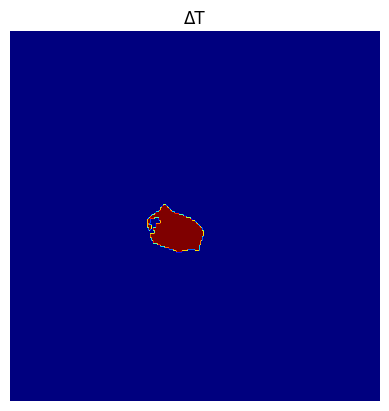

In [74]:
plt.imshow(np.rot90(change_map.squeeze(0)), cmap='jet')
plt.title('ΔT')
plt.axis('off')
plt.show()

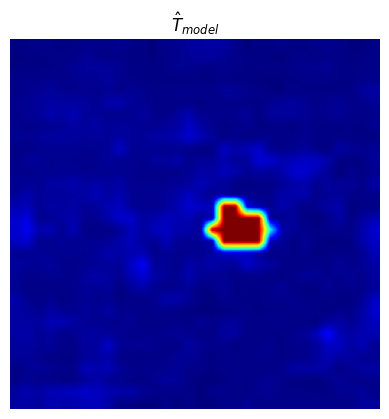

In [75]:
# plt.imshow(np.rot90(change_map), cmap='jet')
plt.imshow(np.rot90(distance_map_2d_conv3), cmap='jet')
plt.title('$\hat{T}_{model}$')
plt.axis('off')
plt.show()

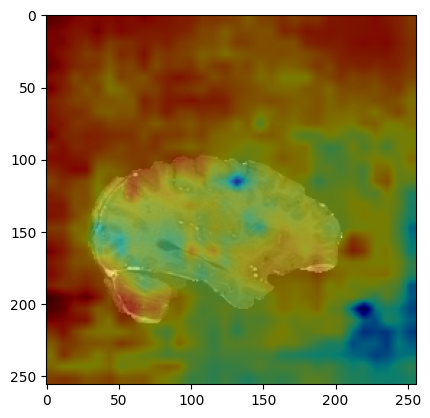

In [76]:
plt.imshow(np.rot90(pre_op), cmap='gray')
plt.imshow(np.rot90(phi0), cmap='jet', alpha=0.5)
# plt.imshow(np.rot90(pre_tumor), cmap='hot', alpha=0.5)

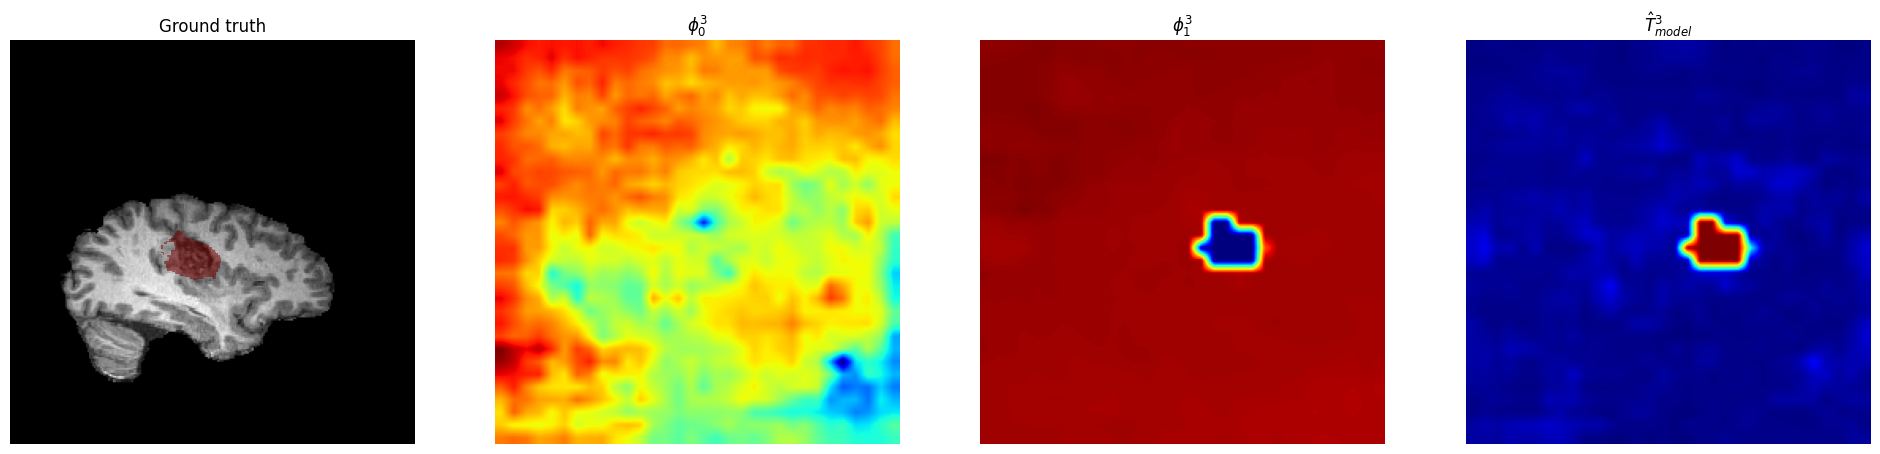

In [89]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1, 4, figsize=(24, 6))


# Plot post_op
axs[0].imshow(np.rot90(post_op.squeeze(0)), cmap='gray')
axs[0].imshow(np.rot90(np.ma.masked_where(change_map == 0, change_map)), cmap='jet', alpha=0.5 , vmin=0.7)
axs[0].set_title('Ground truth')
axs[0].axis('off')

axs[1].imshow(np.rot90(phi0), cmap='jet')
axs[1].set_title('$\phi^3_{0}$')
axs[1].axis('off')

axs[2].imshow(np.rot90(phi1), cmap='jet')
axs[2].set_title('$\phi^3_{1}$')
axs[2].axis('off')

axs[3].imshow(np.rot90(distance_map_2d_conv3), cmap='jet')
axs[3].set_title('$\hat{T}^3_{model}$')
axs[3].axis('off')

plt.show()

(-0.5, 255.5, 255.5, -0.5)

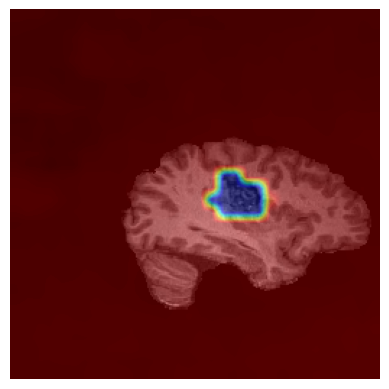

In [ ]:
post_op = shift_tensor(post_op, shift=(shift_values[0], shift_values[1]))

plt.imshow(np.rot90(post_op), cmap='gray')
plt.imshow(np.rot90(phi1), cmap='jet', alpha=0.5)
plt.axis('off')
# meer data -> betere change maps (minder fouten door beter filter) -> leave patietns out -> less overfitting
# of meer data -> 3d models -> betere change maps (filter + no slicing) -> leave patients out -> less overfitting

In [24]:
def multiplicative_sharpening_and_filter(distance_map: np.ndarray, base_image: np.ndarray, alpha=2.0, beta=1, threshold=0.55):
    """Process the distance map with sharpening, without blending with the base image."""
    
    assert distance_map.max() <= 1.0, f"max: {distance_map.max()}"
    assert distance_map.min() >= 0.0, f"min: {distance_map.min()}"
    assert base_image.max() <= 1.0, f"max: {base_image.max()}"
    assert base_image.min() >= 0.0, f"min: {base_image.min()}"

    # Threshold and normalize the distance map
    distance_map = (distance_map > threshold).astype(np.float32) * distance_map

    # Extract high-frequency details from the base image
    blurred_image = cv2.GaussianBlur(base_image, (5, 5), 0)
    high_freq_details = base_image - blurred_image

    # Apply sharpening based purely on the distance map's strength
    sharpened_map = distance_map * (1 + alpha * high_freq_details)

    # Normalize the final enhanced distance map
    norm_enhanced_map = normalize_np_array(sharpened_map)

    return sharpened_map  


In [27]:
sharpened = multiplicative_sharpening_and_filter(distance_map_2d_conv3, post_op.data.cpu().numpy(), alpha=2.0)
masked_sharpened = np.ma.masked_where(sharpened < 0.55, sharpened)

(-0.5, 255.5, 255.5, -0.5)

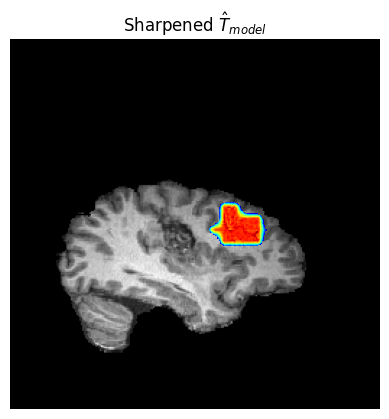

In [ ]:
plt.imshow(np.rot90(post_op), cmap='gray')
plt.imshow(np.rot90(masked_sharpened), cmap='jet')
plt.title('Sharpened $\hat{T}_{model}$')
plt.axis('off')